In [738]:
import pandas as pd
import numpy as np
from typing import Tuple
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [739]:
def get_xgboost_x_y(
    indices: list, 
    data: np.array,
    target_sequence_length,
    input_seq_len: int
    ) -> Tuple[np.array, np.array]:

    """
    Args:

        indices: List of index positions at which data should be sliced

        data: A univariate time series

        target_sequence_length: The forecasting horizon, m

        input_seq_len: The length of the model input, n

    Output: 

        all_x: np.array of shape (number of instances, input seq len)

        all_y: np.array of shape (number of instances, target seq len)

    """
    print("Preparing data..")
    print(indices)
    # Loop over list of training indices
    for i, idx in enumerate(indices):

        # Slice data into instance of length input length + target length
        data_instance = data[idx[0]:idx[1]]
        
        x = data_instance[0:input_seq_len]

        assert len(x) == input_seq_len

        y = data_instance[input_seq_len:input_seq_len+target_sequence_length]

        # Create all_y and all_x objects in first loop iteration
        if i == 0:

            print("FIRST ITEr")
            all_y = y.reshape(1, -1)

            all_x = x.reshape(1, -1)

        else:

            all_y = np.concatenate((all_y, y.reshape(1, -1)), axis=0)

            all_x = np.concatenate((all_x, x.reshape(1, -1)), axis=0)

    print("Finished preparing data!")

    return all_x, all_y


def load_data():

    # Read data
    spotprices = pd.read_csv("/kaggle/input/c1111-8pltexa/N9K-X97160YC-EX.csv", delimiter=",")
    spotprices.dropna()
    
#     target_variable = "SpotPriceEUR"
    target_variable = "Booked_Qty"
    
#     timestamp_col = "HourDK"
    timestamp_col = "Booking_Date"

    # Convert separator from "," to "." and make numeric
#     spotprices[target_variable] = spotprices[target_variable].str.replace(',', '.', regex=True)

    spotprices[target_variable] = pd.to_numeric(spotprices["Booked_Qty"])

    # Convert HourDK to proper date time and make it index
    spotprices[timestamp_col] = pd.to_datetime(spotprices[timestamp_col])
    
    spotprices.index = pd.to_datetime(spotprices[timestamp_col])

    # Discard all cols except DKK prices
    spotprices = spotprices[[target_variable]]

    # Order by ascending time stamp
    spotprices.sort_values(by=timestamp_col, ascending=True, inplace=True)

    return spotprices

def get_indices_entire_sequence(
    data: pd.DataFrame, 
    window_size: int, 
    step_size: int
    ) -> list:
        """
        Produce all the start and end index positions that is needed to produce
        the sub-sequences. 
        Returns a list of tuples. Each tuple is (start_idx, end_idx) of a sub-
        sequence. These tuples should be used to slice the dataset into sub-
        sequences. These sub-sequences should then be passed into a function
        that slices them into input and target sequences. 
        
        Args:
            data (pd.DataFrame): Partitioned data set, e.g. training data

            window_size (int): The desired length of each sub-sequence. Should be
                               (input_sequence_length + target_sequence_length)
                               E.g. if you want the model to consider the past 100
                               time steps in order to predict the future 50 
                               time steps, window_size = 100+50 = 150
            step_size (int): Size of each step as the data sequence is traversed 
                             by the moving window.
                             If 1, the first sub-sequence will be [0:window_size], 
                             and the next will be [1:window_size].
        Return:
            indices: a list of tuples
        """

        stop_position = len(data)-1 # 1- because of 0 indexing
        
        # Start the first sub-sequence at index position 0
        subseq_first_idx = 0
        
        subseq_last_idx = window_size
        
        indices = []
        
        print("stop : " , stop_position , "last idx:" ,subseq_last_idx) 
        while subseq_last_idx <= stop_position:

            indices.append((subseq_first_idx, subseq_last_idx))
            
            subseq_first_idx += step_size
            
            subseq_last_idx += step_size
    
        
        return indices

# Define hyperparameters and other important variables

In [740]:
target_variable = "Booked_Qty"

timestamp_col = "Booking_Date"

target_sequence_length = 1*8

test_size = 0.30

first_day_test = "2019-06-01"

last_day_test = "2025-12-01"

# reuced in length from 7*24 to 4
hyperparameters = {
    "in_length" : 2,
    "step_size" : 12,
    "n_estimators" : 20,
    "max_depth" : 6,
    "subsample" : 0.5,
    "min_child_weight" : 1,
    "selected_features" : [target_variable]
    }

# Prepare data

First, we load the data and split it into train and test. It is important that the shuffle argument is False, because we need to maintain the original order of the data points in the data. 

In [741]:
spotprices = load_data()

In [742]:
training_data = spotprices[spotprices.index < first_day_test]
display(training_data)
print(len(training_data))

,Booked_Qty
Booking_Date,
2017-01-01,57
2017-02-01,38
2017-03-01,172
2017-04-01,281
2017-05-01,148
2017-06-01,244
2017-07-01,299
2017-12-01,52
2018-01-01,258


25


In [743]:
test_data = spotprices[spotprices.index >= first_day_test]
test_data = test_data[test_data.index <= last_day_test]
test_data

,Booked_Qty
Booking_Date,
2019-06-01,637
2019-07-01,912
2019-08-01,138
2019-09-01,403
2019-10-01,884
2019-11-01,450
2019-12-01,640
2020-01-01,485
2020-02-01,208


In [744]:
# Create indices. Must be passed to function that creates (X,Y) pairs so that
# it knows where to slice the data
training_indices = get_indices_entire_sequence(
    data=training_data, 
    window_size=hyperparameters["in_length"]+target_sequence_length, 
    step_size=hyperparameters["step_size"]
    )
print("After get_ind_ent_session",training_indices)
# Obtain (X,Y) pairs of training data
x_train, y_train = get_xgboost_x_y(
    indices=training_indices, 
    data=training_data[hyperparameters["selected_features"]].to_numpy(),
    target_sequence_length=target_sequence_length,
    input_seq_len=hyperparameters["in_length"]
    )

test_indices = get_indices_entire_sequence(
    data=test_data, 
    window_size=hyperparameters["in_length"]+target_sequence_length, 
    step_size=24
    )

# Obtain (X,Y) pairs of test data
x_test, y_test = get_xgboost_x_y(
    indices=test_indices, 
    data=test_data[hyperparameters["selected_features"]].to_numpy(),
    target_sequence_length=target_sequence_length,
    input_seq_len=hyperparameters["in_length"]
    )

stop :  24 last idx: 10
After get_ind_ent_session [(0, 10), (12, 22)]
Preparing data..
[(0, 10), (12, 22)]
FIRST ITEr
Finished preparing data!
stop :  36 last idx: 10
Preparing data..
[(0, 10), (24, 34)]
FIRST ITEr
Finished preparing data!


# Train model

In [745]:
# Initialize model
model = xgb.XGBRegressor(
    n_estimators=hyperparameters["n_estimators"],
    max_depth=hyperparameters["max_depth"],
    subsample=hyperparameters["subsample"],
    min_child_weight=hyperparameters["min_child_weight"],
    objective="reg:squarederror",
    tree_method="hist"
    )

trained_model = MultiOutputRegressor(model).fit(x_train, y_train)

train_forecasts = trained_model.predict(x_train)

# Test model

In [746]:
print(x_test)
test_forecasts = trained_model.predict(x_test)

test_mae = mean_absolute_error(y_test, test_forecasts)
print(test_mae)
print("Mean test data value: {}".format(np.mean(y_test)))

[[637 912]
 [470 830]]
293.3468360900879
Mean test data value: 445.6875


# Plot forecasts against targets

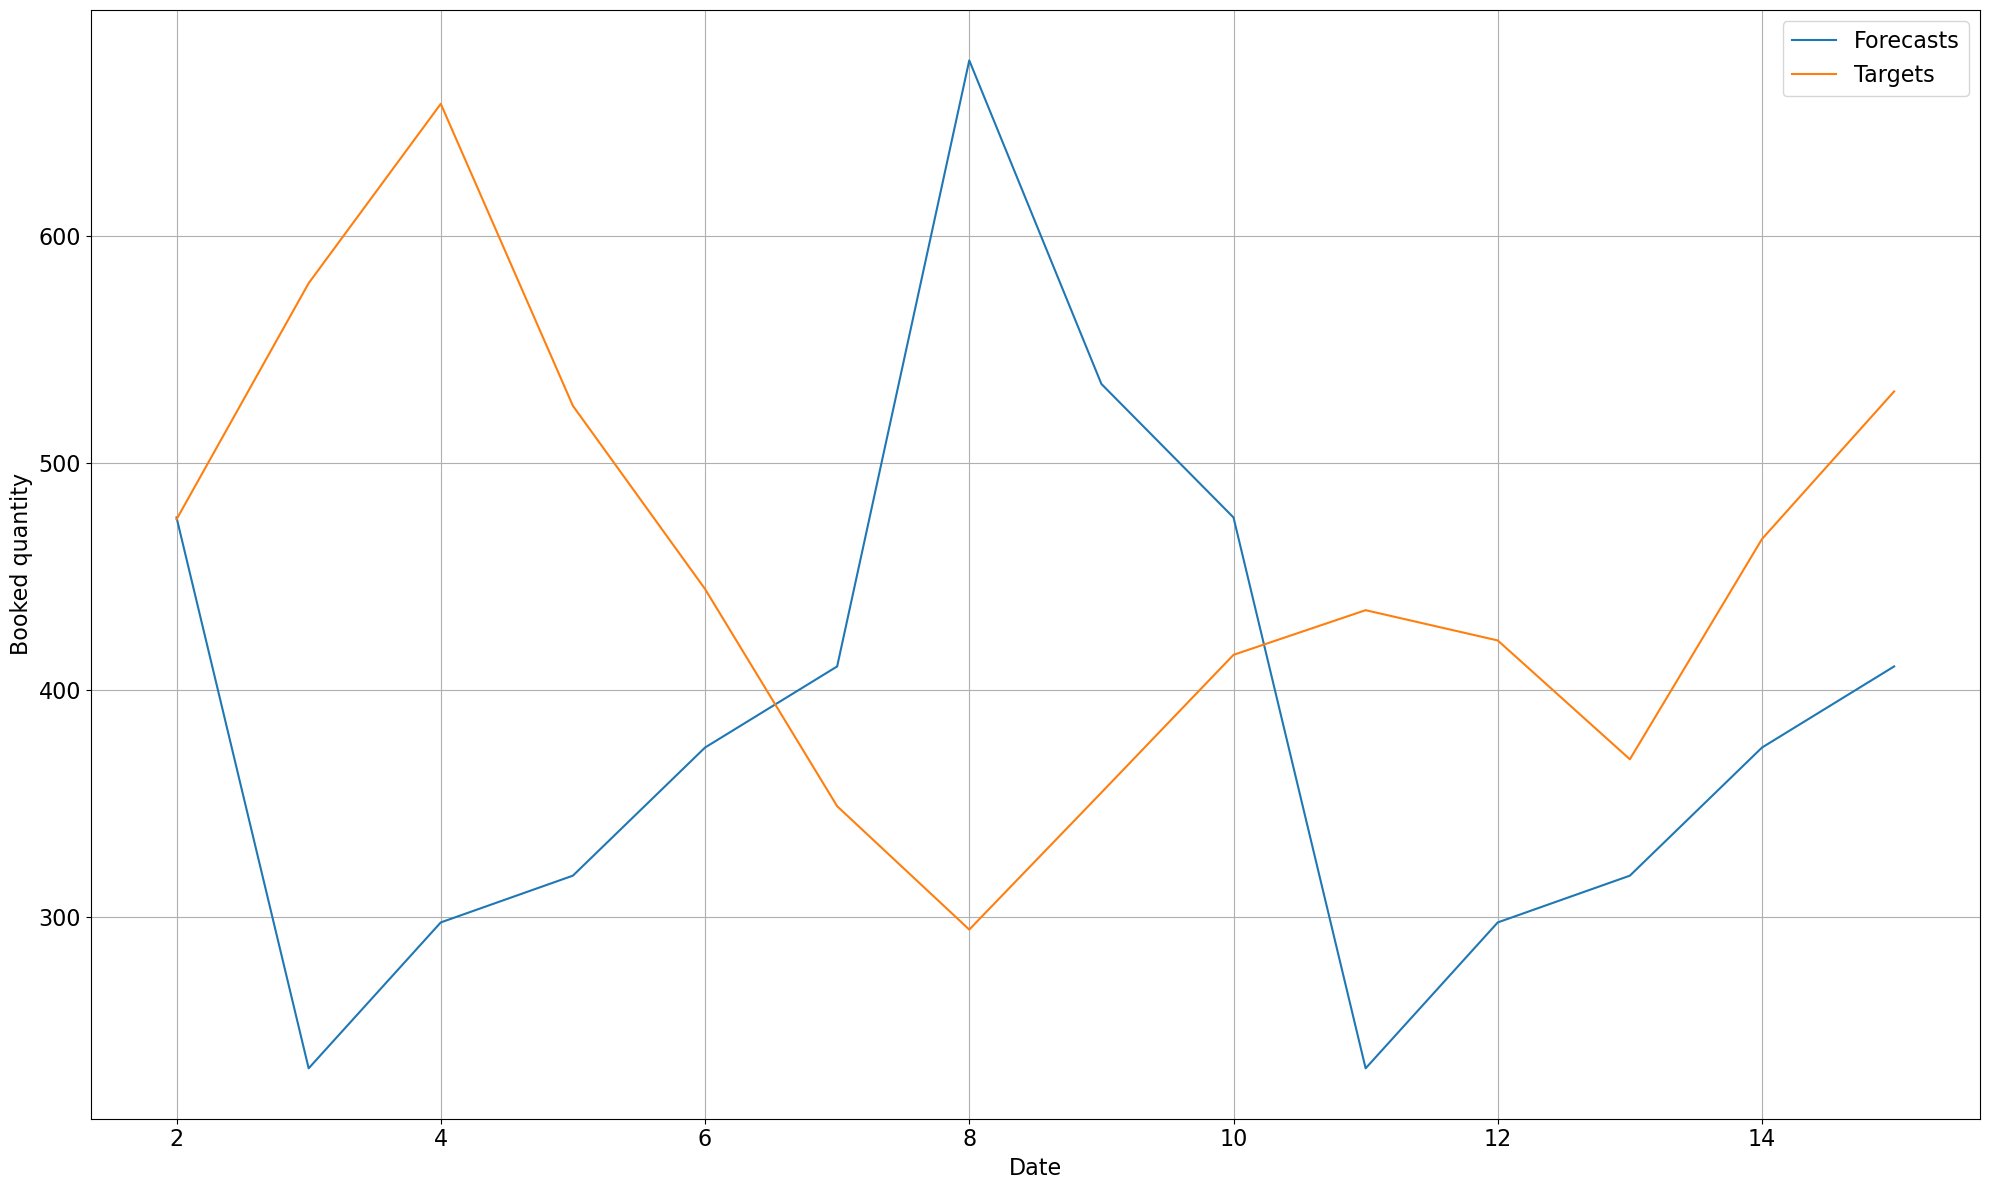

In [747]:
fontsize = 16
plot_df = pd.DataFrame({"Forecasts" : test_forecasts.flatten(), "Targets" : y_test.flatten()}, index=range(len(y_test.flatten())))

fig = plt.figure(figsize=(20,12))
plt.plot(plot_df.index, plot_df["Forecasts"].rolling(3).mean(), label="Forecasts")
plt.plot(plot_df.index, plot_df["Targets"].rolling(3).mean(), label="Targets")

plt.xlabel('Date', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("Booked quantity", fontsize=fontsize)
plt.grid(True)
plt.legend(fontsize=fontsize)
plt.tight_layout()

In [748]:
print( "relative error" , ( test_mae / sum(y_test)/len(y_test))[0]  * 100 , "%")

relative error 31.885525661966074 %


In [759]:
# from time import sleep
tempout = [[21432,39989],[23162,46255]]
# n=20
# while(n!=0):
#     n-=1
predval = trained_model.predict(tempout)
#     tempout = [ [tempout[0][1] , tempout[1][0]] ,[ tempout[1][1], predval] ]
#     tempout.pop(0)
print(predval)
    
#     tempout = np.array(tempout)
#     tempout =   tempout.reshape((2,2))
    
#     sleep(1)

# print(trained_model.predict(tempout)[0][0])

[[1091.9886    105.979675  229.50092   364.20145   298.75668   291.27524
   533.46045   405.9286  ]
 [1091.9886    105.979675  229.50092   364.20145   298.75668   291.27524
   533.46045   405.9286  ]]


In [750]:

# tempout = [[-10,-20],[-99990,-99990]]
# predval = trained_model.predict(tempout)
# print(predval)
